#### About this repository:

The notebooks in this repository are meant to serve as comprehensive building blocks for establishing an algorithmic trading system. 
 
A number of sample trading strategies are included, along with methodologies to determine their robustness. Walk-Forward Analysis is one such well known technique, while Combinatorial Purged Cross Validation is a newer and more  rigorous methodology. Another useful and important concept is Meta Labelling, which predicts the probability of individual winning trades. All three techniques are utilized here to help improve the rigor of the systematic trading research process. 

Even though the methodologies presented in these notebooks can always be fine-tuned further, they are sophisticated enough to provide rigorous backtesting of any algorithmic trading strategy. After looking through this repository, one should gain an understanding of how algorithmic trading startegies are programmed and backtested. Identifying such strategies can simply be a matter of adapting algorithms found in research journals or trading websites; the aim of these notebooks is to determine a strategy's profitability and robustness. The final step of live trading a strategy should be merely trivial rewriting of a few lines of code in the Zipline version of the strategy. 


*Hoa Tuan Nguyen:* http://linkedin.com/in/hoatuannguyen/

## Support and Resistance Strategy:

This strategy uses support (S) and resistance (R) level to generate trading signals. 

S and R can be calculated from the 'pivot point' C, which is calculated as follows:

- C = (P_h + P_l + P_c) /3 
- R = 2 * C - P_l
- S = 2 * C - P_h

Where P_h, P_l, P_c is previous day's high, low, and closing prices. 

The trading signals are generated in the following manner (where P is the current price):

- Establish longs if P > C
- Establish shorts if P < C
- Liquidate longs if P >= R
- Liquidate shorts if P <= S 

For the particular version of this strategy below, I used a fast moving average instead of P to generate signals. Also, instead of using the previous day's high, low, and closing prices, I optimized for the best look back window. The window for calculating the fast mva and the multiplier (instead of 2 as above) used to calculate S and R are also optimized. 

This strategy is then passed through Combinatorial Purged Cross Validation to determine its robustness. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('ticks')
%matplotlib inline

import optuna
import empyrical
import pyfolio

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [3]:
df = pd.read_csv('btc_2019_aug6_2020.csv', index_col=0, parse_dates=True)

In [19]:
df.index = df.index.tz_localize(None)

In [20]:
df.head()

,close,high,low,open,volume
2019-01-01 00:00:00,3694.5,3694.5,3693.0,3693.0,241.351087
2019-01-01 00:01:00,3690.5,3694.5,3690.5,3694.5,178.451678
2019-01-01 00:02:00,3690.5,3691.0,3690.5,3690.5,53.144116
2019-01-01 00:03:00,3690.0,3691.0,3690.0,3690.5,71.344447
2019-01-01 00:04:00,3688.5,3690.5,3688.5,3690.5,194.159810


### Explore with a few random parameters' values

In [8]:
Ph = df.close.rolling(1440).max()
Pl = df.close.rolling(1440).min()
Pc = df.close
c = (Ph+Pl+Pc)/3
r = 2*c-Pl
s = 2*c-Ph

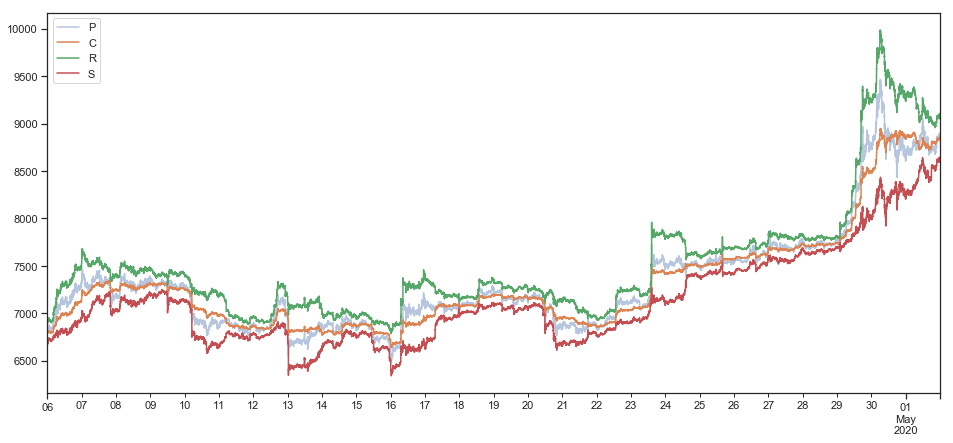

In [9]:
df.close.loc['2020-04-06':'2020-05-01'].plot(figsize=(16,7), alpha=.4, label='P')
c.dropna().loc['2020-04-06':'2020-05-01'].plot(label='C')
r.dropna().loc['2020-04-06':'2020-05-01'].plot(label='R')
s.dropna().loc['2020-04-06':'2020-05-01'].plot(label='S')
plt.legend()

### Code up the strategy

In [5]:
# helper function to calculate Pessimistic Return on Margin from a cumulative return pandas series

def PROM(cumRet):
    trade_rets = cumRet-cumRet.shift(1).fillna(1)
    win_trades = trade_rets[trade_rets>0]
    lose_trades = trade_rets[trade_rets<0]
    adj_wins = len(win_trades) - np.sqrt(len(win_trades))
    adj_losses = len(lose_trades) + np.sqrt(len(lose_trades))
    avg_win = win_trades.mean()
    avg_lose = lose_trades.mean()
    return avg_win*adj_wins+avg_lose*adj_losses

In [6]:
# helper function that returns daily returns for non-continuous cummulative returns

def dailyRet_noncont(cumRet):
    cumRet = cumRet.resample('1T').mean().fillna(method='ffill')
    return (cumRet.resample('1D').last()/cumRet.resample('1D').last().shift(1)-1).dropna()

In [7]:
# Support and Resistance Strategy function 
# modified a little to be compatible with Combinatorial Purged Cross Validation

def support_n_resistance_cpcv(data, wd, fast, mult, pt=.04, sl=-.015):
    long_pos = False
    short_pos = False
    
    take_profit = 0    # help debug
    stopped_out = 0    # help debug
    pos_ret = 0   # help debug
    neg_ret = 0   # help debug
    filled_price = 0
    PnL = 1
    cumRet = []    
    
    # rolling function below has same effect as purging the data to avoid overlapped information in time series
    # purging is important in cross validating time series data. See Cross Validation chapter in Advances in FinML
    # cumRet returned by this function will thus have fewer data points than those from the original data input
    # embargoing the data can further improve the robustness of this process (to be implemented)
    # shift by 1 minute to avoid any kind of look forward bias
    data['fast'] = data.close.shift(1).rolling(fast).mean()
    data['PH'] = data.close.shift(1).rolling(wd).max()
    data['PL'] = data.close.shift(1).rolling(wd).min()
    data['PC'] = data.close.shift(1)
    data.dropna(inplace=True)
    data.index = data.index.astype(int)   # convert time stamp index to unix

    # to keep track of trades closed due to data jumping from one test/train group to another disparate one
    eop_close = 0         # help debug
    eop_prct_change = 1   # help debug
    jump = 0   # help debug
    last = [data.index[0], 0]   # just need last to be a tuple/list to be compatible with below
                                # when 'last' is assigned 'row'
    one_sec = 60*10**9   # since time was converted to unix 
    
    # loop through every minute data point in the dataset 
    # index=True to accommodate dealing with previous non-contiguous group
    for row in data.itertuples(index=True):   
        P = row.close
        PH = row.PH
        PL = row.PL
        PC = row.PC
        C = (PH+PL+PC)/3
        R = mult*C-PL
        S = mult*C-PH
        fast_mva = row.fast
        has_pos = long_pos + short_pos
        
        # deal with positions from previous non-contiguous group
        if has_pos and row[0] - last[0] > one_sec: 
            if long_pos:
                prct_changed = (last.close - filled_price) / filled_price
            else:
                prct_changed = (filled_price - last.close) / filled_price
            jump += 1        # to help debug
            eop_close += 1   # to help debug
            eop_prct_change *= (1+prct_changed)   # to help debug
            PnL *= (1+prct_changed)
            if prct_changed > 0:
                pos_ret += 1
            else:
                neg_ret += 1           
            long_pos = False
            short_pos = False
        elif row[0] - last[0] > one_sec:
            jump += 1    # to help debug
        
        # put on short trades
        if not has_pos and fast_mva < C and fast_mva*.995 < P:    # added slippage
            filled_price = P
            short_pos = True

        # put on long trades
        elif not has_pos and fast_mva > C and fast_mva*1.005 > P:    # added slippage
            filled_price = P
            long_pos = True

        # close positions, take profits, or stop losses
        elif has_pos:
            if short_pos:
                prct_changed = (filled_price-P)/filled_price
            else:
                prct_changed = (P-filled_price)/filled_price
                
            if fast_mva <= S and short_pos:   # close short positions
                short_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)       # record realized PnL
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif fast_mva >= R and long_pos:  # close long positions
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)       # record realized PnL
                if prct_changed > 0:
                    pos_ret += 1
                else:
                    neg_ret += 1
            elif prct_changed >= pt:          # take profits
                short_pos = False
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)
                take_profit += 1
                pos_ret += 1
            elif prct_changed <= sl:          # stop losses
                short_pos = False
                long_pos = False
                filled_price = 0
                PnL *= (1+prct_changed)
                stopped_out += 1
                neg_ret += 1
        last = row 
        cumRet.append(PnL)

    data.index = pd.to_datetime(data.index)   # convert back to normal timestamp
    cumRet = pd.Series(cumRet, index=data.index)
    print('take profits:',take_profit, '\nstopped out:', stopped_out, 
          '\npos_ret:', pos_ret, '\nneg_ret:', neg_ret, '\neop_closes:',
          eop_close, '    eop_prct_change', eop_prct_change, '    jump:', jump, '\n')         
    
    # return cummulative returns and sum of Pessimistic Return on Margin and Maximum Drawdown
    return cumRet, PROM(cumRet)+empyrical.max_drawdown(dailyRet_noncont(cumRet))

In [8]:
# a quick run with some random value to see if everything works properly

cumRet, pmdd = support_n_resistance_cpcv(df.loc[:'2019-12-31'].copy(), 720, 70, 2)

take profits: 175 
stopped out: 403 
pos_ret: 263 
neg_ret: 491 
eop_closes: 0     eop_prct_change 1     jump: 0 



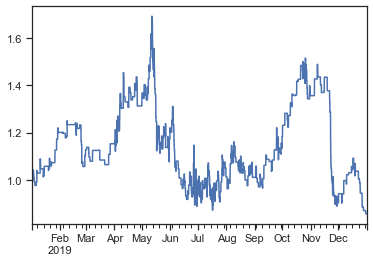

In [9]:
cumRet.plot()

In [10]:
pmdd

-1.573911293027491

### Use Combinatorial Purged Cross Validation to determine the robustness of this strategy

In [11]:
# maximize PROM + max drawdown to find parameters that yield strategies with reasonable max drawdown 
# and high porportion of positive trades (versus strategies with a few big wins)

def cv_obj(trial, data):
    window = int(trial.suggest_discrete_uniform('window', 540, 4860, 360))
    fast = int(trial.suggest_discrete_uniform('fast', 30, 300, 15))
    mult = trial.suggest_discrete_uniform('multiplier', 1, 3, .1)
    return support_n_resistance_cpcv(data.copy(), window, fast, mult)[1]

In [12]:
# return the group numbers for test sets as well as the corresponding assigned path for each test set
# depends on implementation of itertools' combinations 
# and thus might not be the most rigorous method for path assignment
# Might be incorrect if itertools' combinations changes behavior

def cpcv_split(num_groups: int, num_tests: int):
    from itertools import combinations
    df = pd.DataFrame(columns=['G'+str(i) for i in range(1,num_groups+1,1)])
    c = list(combinations(range(1,num_groups+1,1), num_tests))
    for i in range(len(c)):
        df = df.append(pd.Series(data=c[i],index=['G'+str(j) for j in c[i]], name='S'+str(i+1)))
    df = df.fillna(0)
    return df.astype('int'), (df!=0).cumsum(axis=0)[df!=0].fillna(0).astype('int')

In [13]:
# return number of paths for given number of groups and test sets

def get_num_paths(num_groups: int, num_tests: int) -> int:
    from scipy.special import comb
    return int(comb(num_groups, num_groups - num_tests) * num_tests / num_groups)

In [14]:
# helper function
# get individual trades' PnL's from cumRet

def rets_from_cumrets(cumRet):
    rets = (cumRet/cumRet.shift(1)-1).dropna()
    return rets[rets!=0]

In [15]:
# helper function that returns cummulative returns from individual trades' returns

def cumRet_from_rets(rets):
    return (rets+1).cumprod()

In [16]:
# function to cross validate using the Combinatorial Purged Cross Validation technique
# modified slightly from the same function in the Combinatorial Purged Cross Validation notebook
# with a few minor tweaks can be used for other strategies, as was done here

def cpcv_for_support_n_resistance(data, objective, num_groups=5, num_tests=2, num_trials=10):
    import optuna
    from datetime import timedelta
    
    # get the splits and paths
    assignment, paths = cpcv_split(num_groups, num_tests)
    numPaths = get_num_paths(num_groups, num_tests)
    
    # store returns for every path
    returns = [pd.Series(dtype='float16') for i in range(numPaths)] 

    # loop through every split
    for i in range(assignment.shape[0]):
        asg = assignment.iloc[i][assignment.iloc[i]!=0]   # the test groups for this split
        path = paths.iloc[i][paths.iloc[i]!=0]   # the corresponding path for each test group in this split
        group_size = int(data.shape[0]/num_groups)   # size of each group
        print('\n\ntest sets: ', asg.values, '    path: ', path.values)

        # split out test set and train set from the given data frame
        test_sets = []
        test_indices = []
        for i in range(len(asg)):
            start = group_size*(asg[i]-1)
            end = group_size*asg[i]
            print('start: ', start, ' , end: ', end)
            test_sets.append(data.iloc[start:end])
            if end == data.shape[0]:
                end -= 1
            test_indices.append((data.index[start], data.index[end]))
        test_sets = pd.concat(test_sets)
        train_sets = data[~data.index.isin(test_sets.index)]
        # for all practical purpose, num_groups << data.shape[0], thus it is safe to 
        # leave out the last few straggling data points 
        remainder = data.shape[0] % num_groups
        if asg[-1] == num_groups and remainder:            
            train_sets = train_sets[:-remainder]

        # optimize strategy on train sets using Optuna package
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective(trial, train_sets.copy()), n_trials=num_trials)
        params = study.best_params
        print(asg.values, ': ', params, ' with best value: ', study.best_value)

        # run strategy on test sets
        # modified here to work with the strategy of interest
        cr_test = support_n_resistance_cpcv(test_sets.copy(), 
                            int(params['window']), int(params['fast']), params['multiplier'])[0]

        # assign rets to the corresponding path
        for i in range(len(path)):
            start = test_indices[i][0]
            end = test_indices[i][1]-timedelta(minutes=1)
            rets = rets_from_cumrets(cr_test.loc[start:end])
            print('start: ', start, ' , end: ', end)
            returns[path[i]-1] = pd.concat([returns[path[i]-1], rets])
                                            
    return returns

In [25]:
returns_cv = cpcv_for_support_n_resistance(df, cv_obj, 8, 3, 40)

In [26]:
cumRets = []
for i in range(len(returns_cv)):
    cumRets.append(cumRet_from_rets(returns_cv[i]))

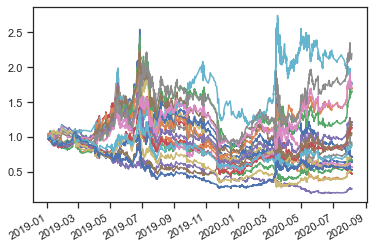

In [27]:
for i in range(len(cumRets)):
    cumRets[i].plot()

In [29]:
#import pickle
#pickle.dump(returns_cv, open( "support_n_resist_cpcv_8_3.pickle", "wb" ) )